### Here is contained all data processing code for my master Thesis

In [1]:
import re,os
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
# re patterns
pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'received_s: (\d+) received_ns: (\d+)'

base_dir=os.path.join("data/wildcards/10ns/")


# get difference in timespec
def timespec_difference(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

- boxplot
- metrics in S
- check consistency of all data

real r505n006    , Rank 001: seconds 7193676, nanosecond 80357538
dummy r505n007    , Rank 002: seconds 16777072, nanosecond 673656936
pub r505n005    , Rank 000: seconds 7260791, nanosecond 680214187

## Retrive data

In [ ]:
# real r505n006    , Rank 001: seconds 7193676, nanosecond 80357538
# dummy r505n007    , Rank 002: seconds 16777072, nanosecond 673656936
# pub r505n005    , Rank 000: seconds 7260791, nanosecond 680214187
pub_s = 7260791 
pubns = 680214187
sub_s_dummy = 16777072
subns_dummy = 673656936
sub_s = 7193676
subns = 80357538

def timespec_difference_without_skew(start_s, start_ns, end_s, end_ns):
    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

# get difference in timespec
def timespec_difference(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s,subns, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff
def timespec_difference_dummy(start_s_un, start_ns_un, end_s_un, end_ns_un):
    start_s,start_ns=timespec_difference_without_skew(pub_s,pubns,start_s_un,start_ns_un)
    end_s,end_ns=timespec_difference_without_skew(sub_s_dummy,subns_dummy, end_s_un, end_ns_un)

    s_diff = end_s - start_s
    ns_diff = end_ns - start_ns 
    if ns_diff < 0:
        ns_diff += 1e9
        s_diff -= 1
    return s_diff, ns_diff

In [2]:
sequence = [1,2,4,6,8,10,12]
protocols = ["udp"] #, "udpM"] #For now considering only udp

sent_data = defaultdict(list)
received_data =defaultdict(list)
sent_data_dummy = []
received_data_dummy = []

for seq in sequence:
    for prots in protocols:
        # Pub part
        file_path= os.path.join(base_dir,f'pubs/pub_{prots}_part+_{seq}.data')
        with open(file_path, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[seq].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
        # Sub part
        for numb in range(1,seq+1):
            for j in range( int(48 / seq) ):
                file_path= os.path.join(base_dir,f'group{seq}/sub_{prots}_part{numb}_{j}.data')
                with open(file_path, 'r') as file: 
                    for line_n,content in enumerate(file):
                        match = re.search(sub_pattern, content)
                        if match:
                            received_s, received_ns = match.groups()
                            start_s,start_ns = ((sent_data[seq][line_n][2], sent_data[seq][line_n][3]))
                            s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                            received_data[seq].append((s_diff, ns_diff))

## Outsider
for prots in protocols:
    file_path= os.path.join(base_dir,f'pubs/pub_{prots}_outsider_0.data')
    with open(file_path, 'r') as file: 
                    for line in file:
                        match = re.search(pub_pattern, line)
                        if match:
                            cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                            sent_data_dummy.append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
    for j in range(48):
        file_path= os.path.join(base_dir,f'groupd/sub_{prots}_outsider_{j}.data')
        with open(file_path, 'r') as file: 
            for line_n,content in enumerate(file):
                match = re.search(sub_pattern, content)
                if match:
                    received_s, received_ns = match.groups()
                    start_s,start_ns = ((sent_data_dummy[line_n][2], sent_data_dummy[line_n][3]))
                    s_diff, ns_diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns))
                    received_data_dummy.append((s_diff, ns_diff))



## Cleaning data

In [3]:

column_time = {}
column_time_dummy = []

# Convert data to timespec
for ngroup in received_data:
    list_difference=[]
    nlen= len(received_data[ngroup])
    for cycle_data in received_data[ngroup]:
        list_difference.append(cycle_data[0] + cycle_data[1] /1e9) # time in second
    column_time[ngroup]=list_difference
    print(np.average(column_time[ngroup]))

    
for cycle_data in received_data_dummy:
    column_time_dummy.append( cycle_data[0] + cycle_data[1] / 1e9 )# time in second


# Remove outliers
lower_bound, upper_bound = calculate_iqr(column_time_dummy)
column_time_dummy_cleaned = [x for x in column_time_dummy if lower_bound <= x <= upper_bound]
column_time_cleaned = {}
print(np.average(column_time_dummy),np.average(column_time_dummy_cleaned))
for ngroup, data in column_time.items():
    lower_bound, upper_bound = calculate_iqr(data)
    column_time_cleaned[ngroup] = [x for x in data if lower_bound <= x <= upper_bound]

-67115.59601427644
-67115.59641334512
-67115.5956399407
-67115.59640568939
-67115.59640985233
-67115.59644344839
-67115.59640973061
9516280.993644146 9516280.993641721


## Bar Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 1000x600 with 0 Axes>

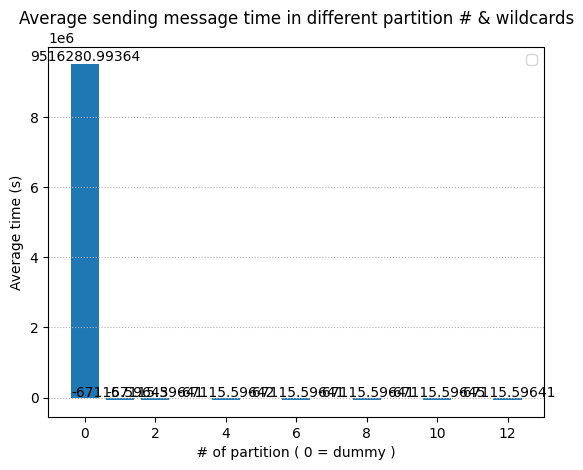

In [4]:
# Prepare data for bar plot
column_averages={}
for ngroup, data in column_time_cleaned.items():
    column_averages[ngroup] = np.average(column_time_cleaned[ngroup])
column_averages[0] = np.average(column_time_dummy_cleaned)

bar_labels = ['dummy', '1group', '2groups', '4groups','8groups','10groups','12groups']
bar_colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green','tab:purple','tab:pink','tab:cyan','tab:olive']

xvalues=[0]
xvalues.append(1)

yvalues=[column_averages[0]]
yvalues.append(column_averages[1])
for n in range(2,13,2):
    xvalues.append(n)
    yvalues.append(column_averages[n])
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
bars= ax.bar(xvalues,yvalues)
# Add values inside each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')
plt.xlabel(" # of partition ( 0 = dummy ) ")
plt.ylabel("Average time (s)")
plt.legend()
plt.title("Average sending message time in different partition # & wildcards")
plt.grid(axis='y', linestyle=':')
plt.show()

## Box Plot

maxlenght is 4800
Fixing dimension of :  1 4410 4800
Fixing dimension of :  2 4798 4800
Fixing dimension of :  4 4653 4800
Fixing dimension of :  6 4797 4800
Fixing dimension of :  10 3981 4800
Fixing dimension of :  12 4798 4800
dict_keys([1, 2, 4, 6, 8, 10, 12])
data


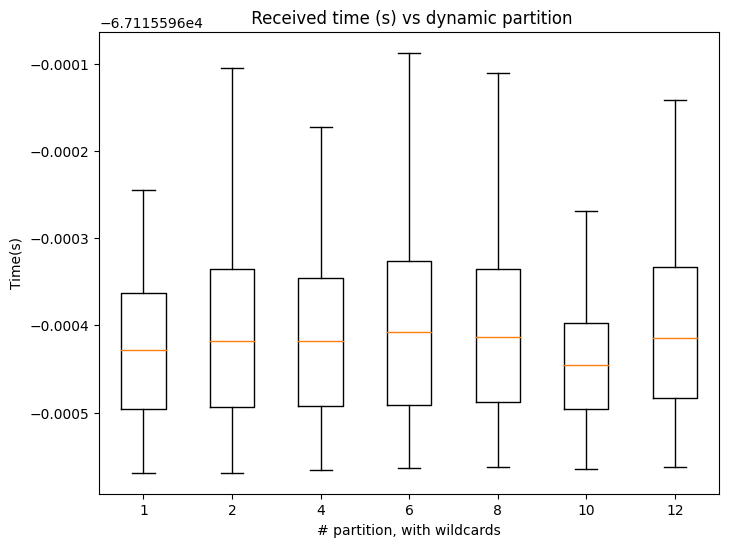

In [5]:
maxlenght = max(len(data) for data in column_time_cleaned.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for ngroup, data in column_time_cleaned.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",ngroup,len(data),maxlenght)
        column_time_cleaned[ngroup] += [column_averages[ngroup]] * (maxlenght-len(data))
        #print([column_averages[ngroup]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time_cleaned.values(),data=column_time_cleaned.keys(),labels=sequence)
plt.title(" Received time (s) vs dynamic partition")
plt.xlabel("# partition, with wildcards")
plt.ylabel("Time(s)")

print(column_time_cleaned.keys())

print(base_dir.split('/')[0])
plt.savefig(f"results/boxplot_wildcards_{base_dir.split('/')[2]}.png")

plt.show()



maxlenght is 4800
Fixing dimension of :  1 4794 4800
Fixing dimension of :  4 4786 4800
Fixing dimension of :  10 4000 4800
dict_keys([1, 2, 4, 6, 8, 10, 12])
data


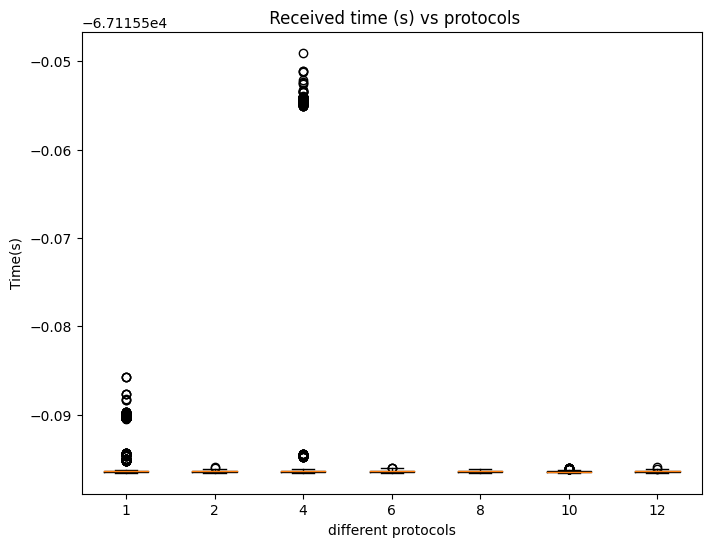

In [6]:
maxlenght = max(len(data) for data in column_time.values())
print("maxlenght is {}".format(maxlenght))

# Need to allineate all data
for prots, data in column_time.items():
    if len(data) < maxlenght:
        print("Fixing dimension of : ",prots,len(data),maxlenght)
        column_time[prots] += [column_averages[prots]] * (maxlenght-len(data))
        #print([column_averages[prots]]* (maxlenght-len(data)))

plt.figure(figsize=(8, 6))
plt.boxplot(x=column_time.values(),data=column_time.keys(),labels=sequence)
plt.title(" Received time (s) vs protocols")
plt.xlabel("different protocols")
plt.ylabel("Time(s)")

print(column_time.keys())

print(base_dir.split('/')[0])
plt.show()

